# Multi-Task Live Selection

To use this notebook, you already should have run the following notebooks:
1. E3_0_Record_and_Segment.ipynb
2. E3_1_Recombination_Selection.ipynb

Summary:
1. This notebook uses already computed scores stored as npz files
2. For each part, compute scores at the front live (current_rgb vs first frame of the part)
3. Compute full trajectory from current state to the goal state

We compute rewards for the shapes: {'trapeze'} using scoring functions {'sum', 'prod'}

In [1]:
import os
import copy
import time
import json
import shutil
import unittest
import subprocess
from pathlib import Path
import numpy as np

from scipy.spatial.transform import Rotation as R

from gym_grasping.envs.robot_sim_env import RobotSimEnv
from flow_control.demo.demo_episode_recorder import record_sim
from flow_control.runner import evaluate_control
from flow_control.servoing.module import ServoingModule
from flow_control.servoing.playback_env_servo import PlaybackEnvServo
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact, Layout
import seaborn as sns
from tqdm import tqdm
import getpass


%matplotlib inline

experiment = "multi_task"
goal = "multi_task_goal"

renderer = 'debug'
task_variant = 'rP'

def get_data_dir():
    username = getpass.getuser()
    if username == "argusm":
        return "/tmp/flow_experiments3"
    elif username == "nayakab":
        return "../tmp"

data_dir = get_data_dir()

root_dir = os.path.join(data_dir, experiment)

pybullet build time: May 20 2022 19:44:17


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load all Demonstrations

In [2]:
def get_recordings(directory):
    return sorted([os.path.join(directory, rec) for rec in os.listdir(directory) if os.path.isdir(os.path.join(directory, rec))])

recordings = get_recordings(root_dir)

<IPython.core.display.Javascript object>


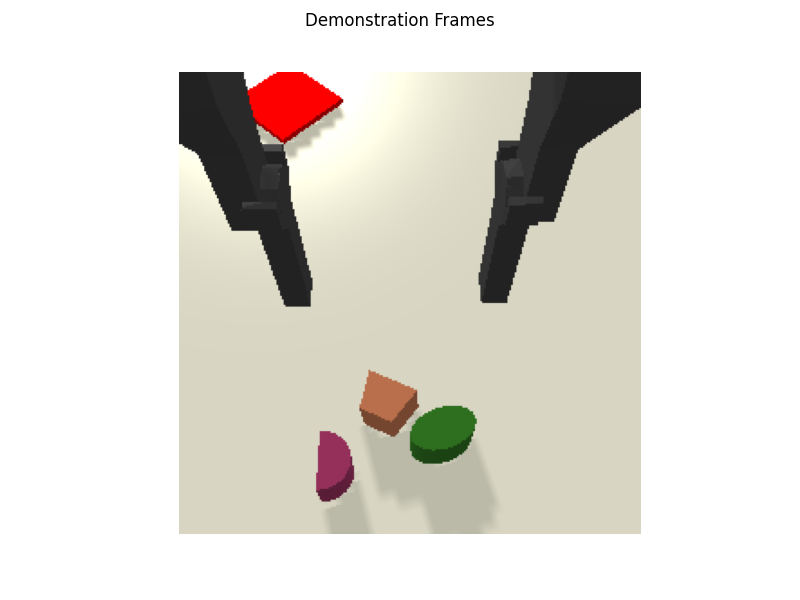

interactive(children=(IntSlider(value=0, description='demo_index', layout=Layout(width='70%'), max=39), IntSli…

<function __main__.update(demo_index, frame_index)>

In [3]:
# Load the demonstration episodes
playbacks = [PlaybackEnvServo(rec) for rec in recordings[:]]

# Plot the demonstrations
%matplotlib notebook
fig, ax = plt.subplots(1,figsize=(8, 6))
fig.suptitle("Demonstration Frames")
ax.set_axis_off()
image_h = ax.imshow(playbacks[0].cam.get_image()[0])

def update(demo_index, frame_index):
    image = playbacks[demo_index][frame_index].cam.get_image()[0]
    image_h.set_data(image)
    fig.canvas.draw_idle()
    print("wp_name:", playbacks[demo_index][frame_index].get_info()["wp_name"])
    fg_mask = playbacks[demo_index].get_fg_mask()
    if fg_mask is not None:
        print("percent fg:", np.mean(fg_mask)*100)
    
slider_w = widgets.IntSlider(min=0, max=len(playbacks)-1, step=1, value=0,
                             layout=Layout(width='70%'))
slider_i = widgets.IntSlider(min=0, max=200-1, step=1, value=0,
                             layout=Layout(width='70%'))

interact(update, demo_index=slider_w, frame_index=slider_i)

# Read scores (errors) from the stored files

In [4]:
error_matrix = np.load(f"{root_dir}/error_matrix.npz")['arr_0']
score_matrix = 1 - error_matrix

# Errors wrt goal images
scores_rear = {}
tasks = ['pnp', 'ss']
for task in tasks:
    scores_rear[task] = 1 - np.load(f"{root_dir}/errors_rear_{task}.npz")['arr_0']

In [5]:
# Get good demonstrations and demonstration part information
def filter_demo(pb):
    return pb[-1].data['rew'] > 0 and np.mean(pb.get_fg_mask()) > 0.005

demo_good = [filter_demo(pb) for pb in playbacks]
good_demonstrations = np.where(demo_good)[0]

good_demonstrations = [int(x) for x in good_demonstrations][0:38]
live_seeds = good_demonstrations[0:39]
print(good_demonstrations)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


In [6]:
# Load demo segmentation file
demo_seg_file = f'{root_dir}/demo_parts_manual2.json'
fp = open(demo_seg_file)
demo_parts = json.load(fp)
live_seeds = [int(key) for key in demo_parts.keys()]
demo_keys = demo_parts.keys()

## Compute live scores 
1. We compute live scores of the current state of the gripper wrt start frames of the part.
2. The part is identified by traj_idx in the function
3. demo_parts contains all the part information and the keyframes relating to each part

In [7]:
from sklearn.preprocessing import minmax_scale

# Load Servoing Module
from flow_control.servoing.module import ServoingModule
control_config = dict(mode="pointcloud-abs-rotz", threshold=0.40)
servo_module = ServoingModule(recordings[0], control_config=control_config,
                              start_paused=False)

def compute_current_scores(playbacks, current_rgb, demo_parts, demo_good, traj_idx=0, live_seed=0):    
    sim_errors = np.ones(len(playbacks)) # lower is better
    mean_flows = np.zeros(len(playbacks))

    for demo_seed in good_demonstrations:
        start_idx = demo_parts[str(demo_seed)][traj_idx]['start']
        demo_rgb =  playbacks[demo_seed][start_idx].cam.get_image()[0]
        demo_mask =  playbacks[demo_seed].fg_masks[start_idx]
        error, mean_flow = similarity_from_reprojection(current_rgb, demo_rgb, demo_mask)
        sim_errors[demo_seed] = error
        mean_flows[demo_seed] = mean_flow
    errors_norm = normalize_errors(sim_errors, mean_flows, demo_good)
    scores = 1 - errors_norm
    
    return scores

def similarity_from_reprojection(live_rgb, demo_rgb, demo_mask, return_images=False):
    # evaluate the similarity via flow reprojection error
    flow = servo_module.flow_module.step(demo_rgb, live_rgb)
    warped = servo_module.flow_module.warp_image(live_rgb / 255.0, flow)
    diff = (warped - (demo_rgb / 255.0))
    error = np.linalg.norm((warped - (demo_rgb / 255.0)), axis=2) * demo_mask
    error = error.sum() / demo_mask.sum()
    mean_flow = np.linalg.norm(flow[demo_mask],axis=1).mean()
    if return_images:
        return error, mean_flow, flow, warped
    return error, mean_flow


def normalize_errors(errors, flows, demo_good):
    errors_l = errors[demo_good]
    mean_flows_l = flows[demo_good]
    errors_norm = np.ones(errors.shape)
    w = .5
    errors_norm[demo_good] = np.mean((1*minmax_scale(errors_l), w*minmax_scale(mean_flows_l)),axis=0)/(1+w)
    return errors_norm

In [8]:
# Arrange keypoint information for all parts in a easy to use data structure
def split_keypoints(pb, demo_part):
    demo_keep = sorted(list(pb.keep_dict.keys()))
    keep_all = copy.copy(pb.keep_dict)
    keep_parts = {}
    for p in demo_part:
        if p["start"] == 0:
            p_start = -1
        else:
            p_start = p["start"]

        parts = []
        for demo_index in demo_keep:
            if p_start < demo_index and p["end"] >= demo_index:
                parts.append(demo_index)   

        keep_parts[p["name"]] = parts
        
    # Need to also add the first frame of the 'insert' part to the 'locate' part
    keep_parts['locate'].append(keep_parts['insert'][0])
    return keep_parts

keypoint_info = {}
for demo_seed in good_demonstrations:
    keypoint_info[demo_seed] = split_keypoints(playbacks[demo_seed], demo_parts[str(demo_seed)])

keypoint_info

{0: {'locate': [0, 6, 9, 21, 32], 'insert': [32, 37, 41, 43]},
 1: {'locate': [0, 4, 7, 14, 26], 'insert': [26, 31, 35, 40]},
 2: {'locate': [0, 5, 8, 15, 27], 'insert': [27, 32, 36, 38]},
 3: {'locate': [0, 4, 7, 13, 24], 'insert': [24, 29, 33, 36]},
 4: {'locate': [0, 4, 7, 14, 25], 'insert': [25, 30, 34, 37]},
 5: {'locate': [0, 4, 7, 14, 26], 'insert': [26, 31, 35, 37]},
 6: {'locate': [0, 4, 7, 14, 25], 'insert': [25, 30, 34, 36]},
 7: {'locate': [0, 5, 8, 14, 25], 'insert': [25, 30, 34, 36]},
 8: {'locate': [0, 5, 8, 15, 26], 'insert': [26, 31, 35, 37]},
 9: {'locate': [0, 4, 7, 14, 25], 'insert': [25, 30, 34, 36]},
 10: {'locate': [0, 4, 6, 12, 14, 26], 'insert': [26, 31, 35, 38]},
 11: {'locate': [0, 4, 7, 14, 26], 'insert': [26, 31, 35, 37]},
 12: {'locate': [0, 4, 6, 12, 14, 26], 'insert': [26, 31, 35, 37]},
 13: {'locate': [0, 5, 8, 13, 24], 'insert': [24, 29, 33, 37]},
 14: {'locate': [0, 4, 6, 12, 13, 24], 'insert': [24, 29, 33, 35]},
 15: {'locate': [0, 4, 6, 12, 22], 'in

## Search for best trajectory 

For this experiment, we only consider the 'sum' and 'prod' scoring functions.

The following function computes the cumulative scores starting at each part all the way to the goal state.

For example:

live_state ---- score_matrix_1 ---- score_matrix_2 ---- goal_state 

simplifies to 

live_scores ---- cscore[0] ---- cscore[1] ---- cscore[2]

1. cscore[2] just contains the goal scores
2. cscore[i] is an array of size n ** (num_parts - i)
3. score_matrices = [score_matrix_1, score_matrix_2, and so on]
4. Once the live scores are available, they can be used along with the corresponding cumulative score to find the best demonstration index

In [ ]:
# Compute cumulative scores staring from the goal state
# score_matrices should contain all the computed score matrices in order from live state to goal state

def get_cumulative_scores(scores_rear, score_matrices, score_fn='sum'):
    # Start from goal state, add goal scores to the list
    cumulative_scores = [scores_rear]    
    
    num_demos = scores_rear.shape[0]
    
    # Need to compute cumulative scores from the goal state. Need to reverse the order
    score_matrices.reverse()
    
    # Compute cumulative scores at the start of each part by repeat and broadcast operations
    for idx, sm in enumerate(score_matrices):
        sm = sm.repeat(num_demos ** idx, axis=1)
        if score_fn == 'sum':
            new_scores = sm + cumulative_scores[-1]
        elif score_fn == 'prod':
            new_scores = sm * cumulative_scores[-1]
        new_scores = new_scores.reshape(-1)
        cumulative_scores.append(new_scores)
    
    # Need to reverse this list so that scores are arranged in the direction of traversal
    # This will now be of the format [n ** 3, n**2, n] (3 part case) for n demonstrations
    cumulative_scores.reverse()
    
    return cumulative_scores

score_matrices = [score_matrix]

cumulative_scores = {}
cumulative_scores['sum'] = get_cumulative_scores(scores_rear['pnp'][:, 0], score_matrices, score_fn='sum')
cumulative_scores['prod'] = get_cumulative_scores(scores_rear['pnp'][:, 0], score_matrices, score_fn='prod')

In [ ]:
print([len(x) for x in cumulative_scores['sum']])
print([len(x) for x in cumulative_scores['prod']])

## Compute best demonstration index using live score and cumulative_scores

1. 'score_front' is computed live
2. 'cm_score' contains the cumulative score (flattened) at the corresponding part index
3. 'factor' helps determine the correct index of the demonstration
4. 'score_front' is repeated 'factor' times to enable combining it with the cumulative score.
4. Then, an argmax operation helps find the correct index

In [ ]:
def get_best_part(score_front, cm_score, factor, score_fn='sum'):
    sf = score_front.repeat(factor)
    if score_fn == 'sum':
        best_idx = np.argmax(sf + cm_score) // factor
    elif score_fn == 'prod':
        best_idx = np.argmax(sf * cm_score) // factor
    
    return best_idx    

In [9]:
def get_best_segments(score_front, score_rear, score_matrix, score_fn='min'):
    x, y = score_matrix.shape
    best_score_fn = {'score': 0.0, 'idx1': -1, 'idx2': -1}

    if score_fn == 'min':
        idx1 = np.argmax(score_front)
        idx2 = np.argmax(score_rear)
        best_score_fn['idx1'] = idx1
        best_score_fn['idx2'] = idx2

        return best_score_fn

    for i in range(x):
        for j in range(y):
            total_score_fn = 0.0
            if score_fn == 'sum':
                total_score_fn = score_matrix[i][j] + score_front[i] + score_rear[j]
            elif score_fn == 'prod':
                total_score_fn = score_front[i] * score_matrix[i][j] * score_rear[j]

            if total_score_fn > best_score_fn['score']:
                best_score_fn['score'] = total_score_fn
                best_score_fn['idx1'] = i
                best_score_fn['idx2'] = j

    return best_score_fn

## Evaluation Function 
We evaluate different combinations of experiments here:


In [10]:
# # Evaluation function
# from math import pi
# from flow_control.servoing.module import ServoingModule
# from gym_grasping.envs.robot_sim_env import RobotSimEnv
# from flow_control.runner import evaluate_control
# import ipdb
# import cv2


# selected_recordings = {}
# def eval_cmb(playbacks, demo_good, live_seed, demo_parts, keypoint_info, task, score_fn):
    
#     save_root = f'{data_dir}/multi_task_run/{task}/{score_fn}'
#     cscores = cumulative_scores[score_fn]
   
#     # Instantiate env
#     env = RobotSimEnv(task='recombination', renderer=renderer, act_type='continuous',
#                       initial_pose='close', max_steps=500, control='absolute-full',
#                       img_size=(256, 256), param_randomize=("geom",),
#                       param_info={'object_selected': 'trapeze', 'task_selected': task},
#                       task_info=dict(object_rot_range={"rP":pi/2.,"rR":pi/6.}[task_variant]),
#                       seed=int(live_seed))
    
#     # Mapping part to index
#     traj_map = {0: 'locate', 1: 'insert'}
    
#     # Mapping task name to a short form. These goal scores were stored using these keys
#     task_map = {'pick_n_place': 'pnp', "shape_sorting": "ss"}
    
#     save_dir = None
    
#     # Total number of demonstrations that are used
#     num_demos = scores_rear[task_map[task]].shape[0]
    
#     for idx in range(2):        
#         state, _, _, _ = env.step(None)
        
#         # Get the current gripper state
#         current_rgb = state['rgb_gripper']
        
#         # Compute live scores wrt the first image of the current part under consideration
#         scores_front = compute_current_scores(playbacks, current_rgb, demo_parts, demo_good, traj_idx=idx, live_seed=live_seed)
        
#         # Compute a trajectory, get the demonstration (part) index that maximizes the score
#         best_idx = get_best_part(scores_front, cscores[idx], num_demos ** (1 - idx), score_fn=score_fn)        
#         best_demo = recordings[best_idx]
        
#         # Keypoints for the demonstration part    
#         kp_info = keypoint_info[best_idx]
#         kps = kp_info[traj_map[idx]]
        
#         if idx == 0:
#             selected_recordings[live_seed] = [best_demo]
        
#         if idx == 1:
#             save_dir = f"{save_root}/run_pnp_{live_seed}_{best_idx}"
#             folder_idx = 1
#             updated_dir = save_dir
#             while os.path.isdir(updated_dir):
#                 updated_dir = f"{save_dir}_{folder_idx}"
#                 folder_idx += 1
            
#             save_dir = updated_dir
#             selected_recordings[live_seed].append(best_demo)
            
#         servo_module = ServoingModule(best_demo, control_config=control_config,
#                                       start_paused=False, plot=False, plot_save_dir=None,
#                                       load='select', selected_kp=kps)
#         _, reward, _, info = evaluate_control(env, servo_module, max_steps=130, save_dir=save_dir,
#                                              initial_align=True if idx == 0 else False)
        
#     del env
#     del servo_module
#     return reward

In [11]:
# Evaluation function
from math import pi
from flow_control.servoing.module import ServoingModule
from gym_grasping.envs.robot_sim_env import RobotSimEnv
from flow_control.runner import evaluate_control
import ipdb
import cv2


selected_recordings = {}
for task in ['pick_n_place']:
    for score_fn in ['sum', 'prod']:
        selected_recordings[f'{task}_{score_fn}'] = {}
        
def eval_cmb(playbacks, demo_good, live_seed, demo_parts, keypoint_info, task, score_fn):
    
    save_root = f'{data_dir}/multi_task_run_old_fn/{task}/{score_fn}'
   
    # Instantiate env
    env = RobotSimEnv(task='recombination', renderer=renderer, act_type='continuous',
                      initial_pose='close', max_steps=500, control='absolute-full',
                      img_size=(256, 256), param_randomize=("geom",),
                      param_info={'object_selected': 'trapeze', 'task_selected': task},
                      task_info=dict(object_rot_range={"rP":pi/2.,"rR":pi/6.}[task_variant]),
                      seed=int(live_seed))
    
    # Mapping part to index
    traj_map = {0: 'locate', 1: 'insert'}
    
    # Mapping task name to a short form. These goal scores were stored using these keys
    task_map = {'pick_n_place': 'pnp', "shape_sorting": "ss"}
    
    save_dir = None
    
    for idx in range(2):        
        state, _, _, _ = env.step(None)
        current_rgb = state['rgb_gripper']
        
        scores_front = compute_current_scores(playbacks, current_rgb, demo_parts, demo_good, traj_idx=idx, live_seed=live_seed)

        sm = score_matrix
        if idx == 1:
            sm = np.ones_like(score_matrix)
            
        ### TEMP ####
        best_segments = get_best_segments(scores_front, scores_rear[task_map[task]], sm, score_fn=score_fn)
        #############
        

        best_idx = best_segments[f'idx{idx + 1}']
        
#         return scores_front, current_rgb, best_segments
        best_demo = recordings[best_idx]
    
        kp_info = keypoint_info[best_idx]
        kps = kp_info[traj_map[idx]]
        
        if idx == 0:
            selected_recordings[f'{task}_{score_fn}'][live_seed] = [best_demo]
        
        if idx == 1:
            save_dir = f"{save_root}/run_pnp_{live_seed}_{best_idx}"
            folder_idx = 1
            updated_dir = save_dir
            while os.path.isdir(updated_dir):
                updated_dir = f"{save_dir}_{folder_idx}"
                folder_idx += 1
            
            save_dir = updated_dir
            selected_recordings[f'{task}_{score_fn}'][live_seed].append(best_demo)
        servo_module = ServoingModule(best_demo, control_config=control_config,
                                      start_paused=False, plot=False, plot_save_dir=None,
                                      load='select', selected_kp=kps)
        reward = 0
#         _, reward, _, info = evaluate_control(env, servo_module, max_steps=130, save_dir=save_dir,
#                                              initial_align=True if idx == 0 else False)
        
        best_idx = None
    del env
    del servo_module
    return reward

In [12]:
# Get Servoing Rewards
num_live_seeds = 20
all_rewards = {}

for task in ['pick_n_place']:
    for score_fn in ['sum', 'prod']:
        rewards = []
        for live_idx, live_seed in enumerate(range(num_live_seeds)):
            rew = eval_cmb(playbacks, demo_good, live_seed, demo_parts, keypoint_info, task, score_fn=score_fn)
            rewards.append(rew)
        all_rewards[f"{task}_{score_fn}"] = rewards

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a uni

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use no

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use no

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
semaphore destroyed
Thread TERMINATED
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vend

/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([-0.000796 -0.000796 -0.999999]), will use normalized vector

b3Printf: b3Warning[src/BulletInverseDynamics/MultiBodyTree.cpp,268]:

b3Printf: axis of motion not a unit axis ([0.000796 -0.000796 -0.999999]), will use normalized vector



/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 450.51.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 450.51.05
Vendor = NVIDIA Corporation
Renderer = GeForce RTX 2070 with Max-Q Design/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0


/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nayakab/miniconda3/envs/robot1/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
destroy semaphore
Thread TERMINATED
semaphore destroyed
destroy main semaphore
main semaphore destroyed


In [13]:
selected_recordings['pick_n_place_sum']

{0: ['../tmp/multi_task/_pick_n_place_trapeze_rP_seed026',
  '../tmp/multi_task/_pick_n_place_trapeze_rP_seed026'],
 1: ['../tmp/multi_task/_pick_n_place_trapeze_rP_seed026',
  '../tmp/multi_task/_pick_n_place_trapeze_rP_seed026'],
 2: ['../tmp/multi_task/_pick_n_place_trapeze_rP_seed031',
  '../tmp/multi_task/_pick_n_place_trapeze_rP_seed026'],
 3: ['../tmp/multi_task/_pick_n_place_trapeze_rP_seed021',
  '../tmp/multi_task/_pick_n_place_trapeze_rP_seed026'],
 4: ['../tmp/multi_task/_pick_n_place_trapeze_rP_seed035',
  '../tmp/multi_task/_pick_n_place_trapeze_rP_seed026'],
 5: ['../tmp/multi_task/_shape_sorting_trapeze_rP_seed042',
  '../tmp/multi_task/_pick_n_place_trapeze_rP_seed026'],
 6: ['../tmp/multi_task/_shape_sorting_trapeze_rP_seed050',
  '../tmp/multi_task/_pick_n_place_trapeze_rP_seed026'],
 7: ['../tmp/multi_task/_shape_sorting_trapeze_rP_seed043',
  '../tmp/multi_task/_pick_n_place_trapeze_rP_seed026'],
 8: ['../tmp/multi_task/_shape_sorting_trapeze_rP_seed049',
  '../tmp

In [ ]:
object_uids = {'trapeze': 2, 'oval': 6}
def filter_run(pb, uid):
    return 1 if pb[-1].data['rew'] > 0 and np.atleast_1d(pb[-1].data['info'])[0]['object_selected'] == uid else 0
new_rewards = {}
for task in ['pick_n_place']:
    for score_fn in ['sum', 'prod']:
        run_dir = f'{data_dir}/multi_task_run/{task}/{score_fn}'
        rewards = []
        for run in os.listdir(run_dir):            
            pb = PlaybackEnvServo(os.path.join(run_dir, run))
            rew = filter_run(pb, object_uids['trapeze'])
            rewards.append(rew)
        new_rewards[f"{task}_{score_fn}"] = rewards

In [ ]:
for task in ["pick_n_place"]:
    for score_fn in ['sum', 'prod']:
        key = f"{task}_{score_fn}"
        print(f"{key}: {np.mean(new_rewards[key])}")

In [ ]:
# Evaluation function
from math import pi
from flow_control.servoing.module import ServoingModule
from gym_grasping.envs.robot_sim_env import RobotSimEnv
from flow_control.runner import evaluate_control
import ipdb
import cv2


selected_recordings = {}
for task in ['pick_n_place']:
    for score_fn in ['sum', 'prod']:
        selected_recordings[f'{task}_{score_fn}'] = {}
        
def eval_cmb(playbacks, demo_good, live_seed, demo_parts, keypoint_info, task, score_fn):
    
    save_root = f'{data_dir}/multi_task_run_old_fn/{task}/{score_fn}'
   
    # Instantiate env
    env = RobotSimEnv(task='recombination', renderer=renderer, act_type='continuous',
                      initial_pose='close', max_steps=500, control='absolute-full',
                      img_size=(256, 256), param_randomize=("geom",),
                      param_info={'object_selected': 'trapeze', 'task_selected': task},
                      task_info=dict(object_rot_range={"rP":pi/2.,"rR":pi/6.}[task_variant]),
                      seed=int(live_seed))
    
    # Mapping part to index
    traj_map = {0: 'locate', 1: 'insert'}
    
    # Mapping task name to a short form. These goal scores were stored using these keys
    task_map = {'pick_n_place': 'pnp', "shape_sorting": "ss"}
    
    save_dir = None
    
    for idx in range(2):        
        state, _, _, _ = env.step(None)
        current_rgb = state['rgb_gripper']
        
        scores_front = compute_current_scores(playbacks, current_rgb, demo_parts, demo_good, traj_idx=idx, live_seed=live_seed)

        sm = score_matrix
        if idx == 1:
            sm = np.ones_like(score_matrix)
            
        ### TEMP ####
        best_segments = get_best_segments(scores_front, scores_rear[task_map[task]], sm, score_fn=score_fn)
        #############
        

        best_idx = best_segments[f'idx{idx + 1}']
        
#         return scores_front, current_rgb, best_segments
        best_demo = recordings[best_idx]
    
        kp_info = keypoint_info[best_idx]
        kps = kp_info[traj_map[idx]]
        
        if idx == 0:
            selected_recordings[f'{task}_{score_fn}'][live_seed] = [best_demo]
        
        if idx == 1:
            save_dir = f"{save_root}/run_pnp_{live_seed}_{best_idx}"
            folder_idx = 1
            updated_dir = save_dir
            while os.path.isdir(updated_dir):
                updated_dir = f"{save_dir}_{folder_idx}"
                folder_idx += 1
            
            save_dir = updated_dir
            selected_recordings[f'{task}_{score_fn}'][live_seed].append(best_demo)
        servo_module = ServoingModule(best_demo, control_config=control_config,
                                      start_paused=False, plot=False, plot_save_dir=None,
                                      load='select', selected_kp=kps)
        reward = 0
#         _, reward, _, info = evaluate_control(env, servo_module, max_steps=130, save_dir=save_dir,
#                                              initial_align=True if idx == 0 else False)
        
        best_idx = None
    del env
    del servo_module
    return reward